#  Eikonal Equation segmentation graphs

In [2]:
# load the basic libs
import numpy as np
import matplotlib.image as mpimg
from graph import graph, graph_patch
from utilities import *
from filtering_iso import filtering
from matplotlib import pyplot as plt
from skimage.morphology import opening, square

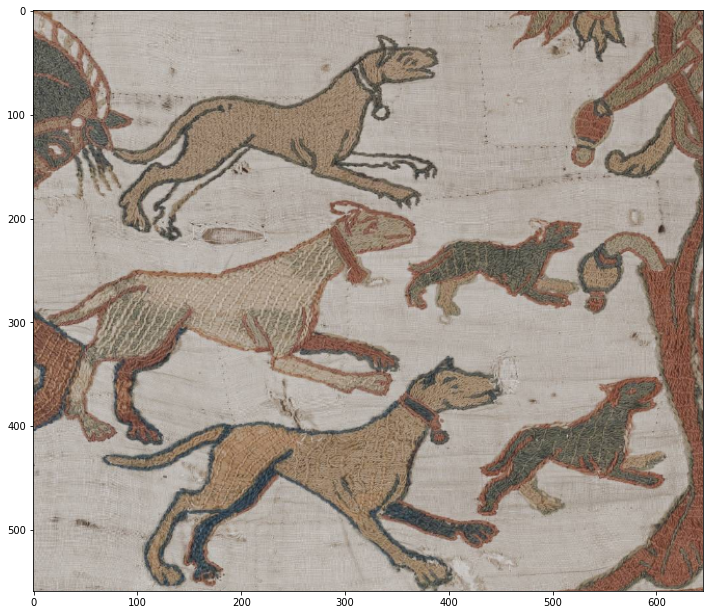

In [54]:
# load the image  # can do the surface example here
img = mpimg.imread("./images/chien_tapestry_bayeux.png")
f = plt.figure(figsize=(12,12))
f.add_subplot(1,1, 1)
plt.imshow(img, cmap="gray")
plt.show()

# Let's filter the image on gpu before creating a graph from it.

In [55]:
fmat = imgPatches(img,(3,3))

ip = graph_patch.initialParams(fmat,30,10000)
gr = graph_patch.buildGraph(ip)

hp = filtering.hyperParams(0.0,500,5e-18,1)

new_fmat = filtering.isoFilter(gr,toFmat(img),hp)
new_img = toImg(new_fmat, img.shape)

/home/azad/phd/lib/python3.6/site-packages/bufferkdtree/neighbors/base.py:257: Warning: 
                The performance of the many-core implementation 
                decreases for large values of 'n_neighbors'!
  , Warning)


<pyopencl.Platform 'NVIDIA CUDA' at 0x3b770d0>
<pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x2a63870>
<pyopencl.Context at 0xc7cd460 on <pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x2a63870>>
total time taken by the gpu python: 12.104803562164307



<pyopencl.Platform 'NVIDIA CUDA' at 0x3b770d0>
<pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x2a63870>
<pyopencl.Context at 0x62ec560 on <pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x2a63870>>
time taken is 19.537885665893555



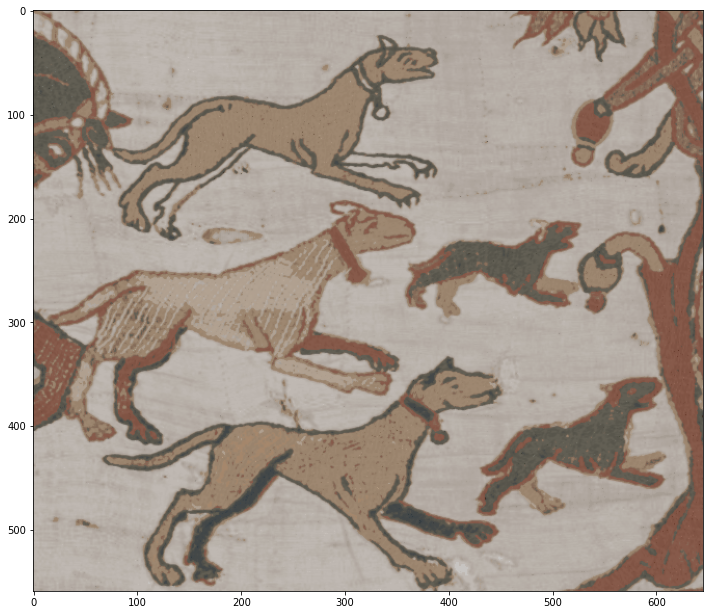

In [56]:
f = plt.figure(figsize=(12,12))
f.add_subplot(1,1, 1)
plt.imshow(new_img, cmap="gray")
plt.show()

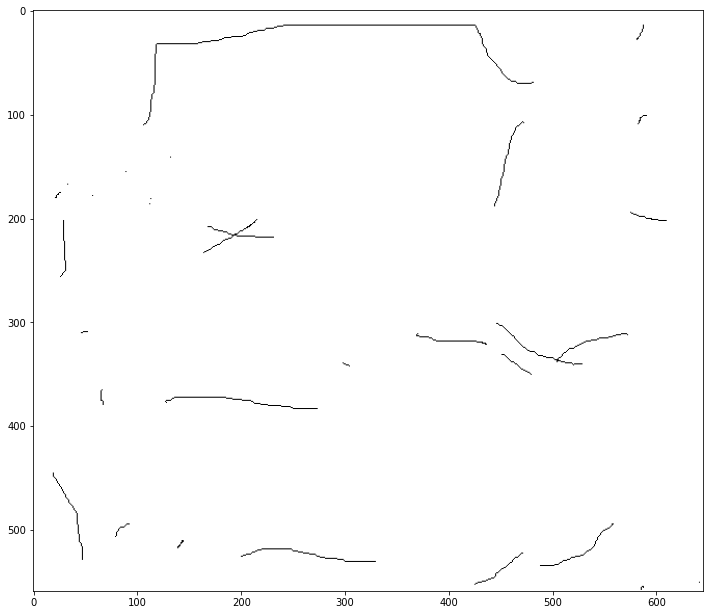

In [57]:
# load the seed image (I have used Pandore(Greyc) library to annotate the image)
Front = []  # tiff should be preffered than png
for i in range(0,1,1):
    seed = mpimg.imread(f"./images/seeds.tiff")
    initial_dist = getDist(np.dstack([seed, seed, seed]))
    Front.append(initial_dist)
    #Front.append(255*intial_dist)
f = plt.figure(figsize=(12,12))
f.add_subplot(1,1, 1)
plt.imshow(Front[0], cmap="gray")
plt.show()

# Create the new graph before running the eikonal equation

In [58]:
new_img = (new_img - np.min(new_img)) / (np.max(new_img) - np.min(new_img))
ip = graph.initialParams(pMat(new_img.shape), toFmat(new_img), 30,0.75e-02)
gr = graph.buildGraph(ip)


<pyopencl.Platform 'NVIDIA CUDA' at 0x3b770d0>
<pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x2a63870>
<pyopencl.Context at 0x8fcf270 on <pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x2a63870>>





In [59]:
# know your weights this can be important at times
# to adjust the values of sigma and k
get_wgStats(gr.wgts)

'The max is 1.0; The min is 0.0; The std is 0.31575489044189453;  The median is 5.175512001187599e-07; The mean is 0.1658708155155182'

# The eikonal equation:
- We shall be runnning the following eikonal equation with the negative $\infty$- norm of the gradient on graphs.
$$ \frac{\partial f}{\partial t} = 1 - \|\nabla_{w}^{-}f\|_{\infty}$$

In [60]:
# evolve the seeds using the graph created above
# for all the seeds in the seed image
from eikonal_eq import eikonal
new_front = []
"""
{{{OPTIMIZATION}}}: azad mer. 12 févr. 2020 08:58:42 CET
Simulatenous evolution of the front on the gpu is possible
and can be deployed. Will make the code much faster.
"""
import time 
start = time.time()
for fr in [Front[0]]:
    hp = eikonal.hyperParams(800)  # iterations
    nf = eikonal.eikonal(gr, toFmat(fr), hp) 
    new_front.append(nf)
end = time.time() - start
print(f"the time taken is {end}")




<pyopencl.Platform 'NVIDIA CUDA' at 0x3b770d0>
<pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x2a63870>
<pyopencl.Context at 0xc7b5d50 on <pyopencl.Device 'GeForce GTX 1080 Ti' on 'NVIDIA CUDA' at 0x2a63870>>

the time taken is 2.253742218017578


# Visualize the distance image

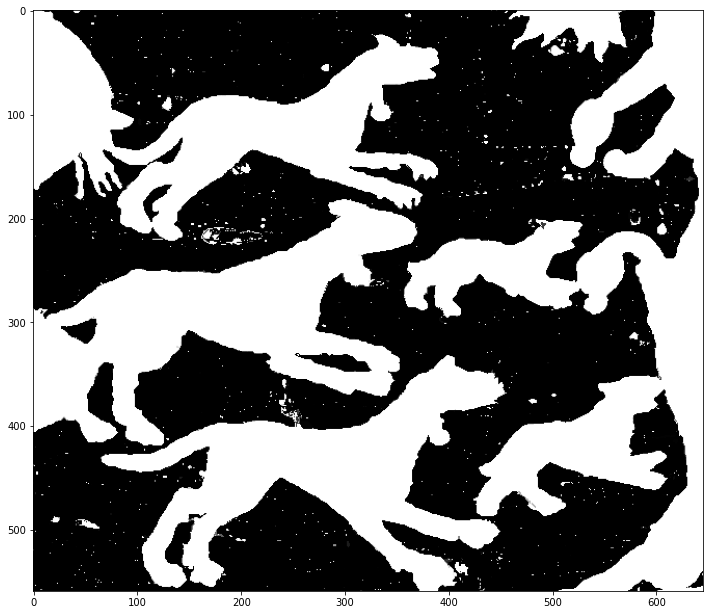

In [61]:
dist_img = []
for fr in new_front:
    tmp_img = toImg(fr, img.shape[0:2])
    dist_img.append(tmp_img)

f = plt.figure(figsize=(12,12))
f.add_subplot(1,1, 1)
plt.imshow(dist_img[0], cmap="gray")
plt.show()

# Process the distance image
- Fitler, morphological operations or thresholding as required.

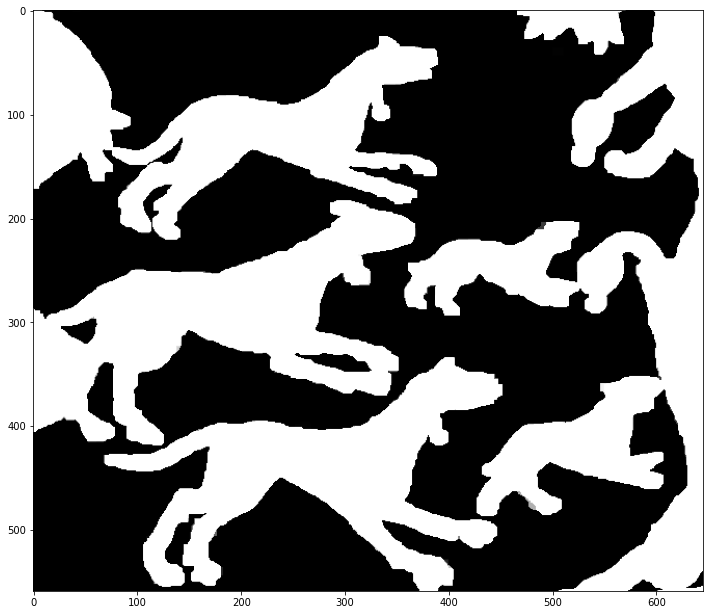

In [62]:
new_img2 = opening(dist_img[0], square(8))
f = plt.figure(figsize=(12,12))
f.add_subplot(1,1, 1)
plt.imshow(new_img2, cmap="gray")
plt.show()

# Visualize the final image segmented image

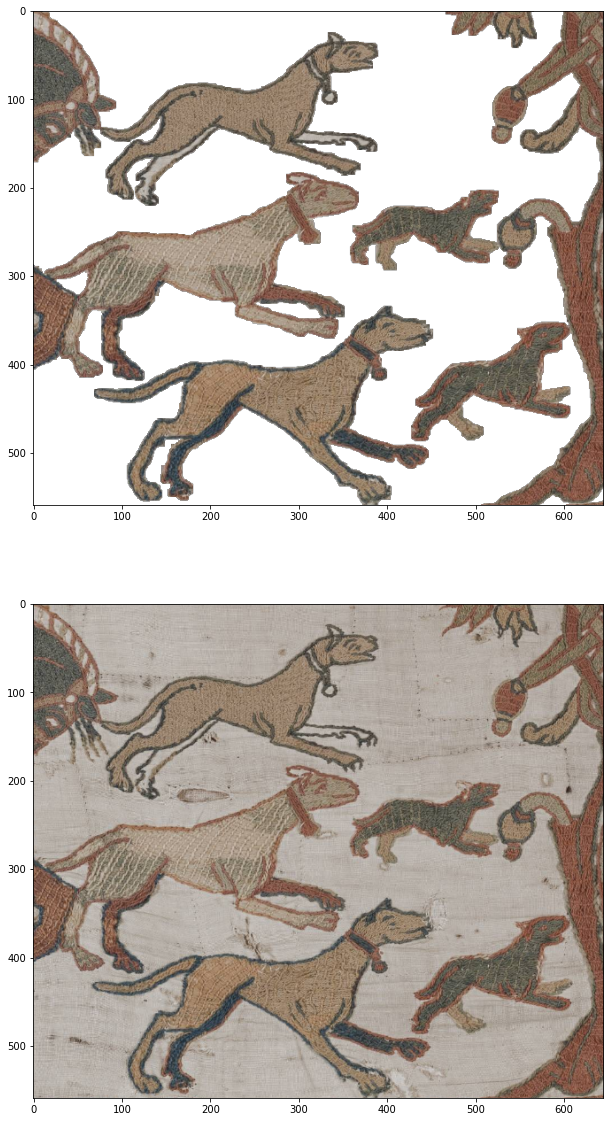

In [63]:
dist2 = (new_img2 - np.min(new_img2)) / (np.max(new_img2) - np.min(new_img2))
dist2 = np.where(dist2 > 0.9, 1, 0)

img3 = np.zeros((img.shape[0], img.shape[1], 4))
img3[:,:,0] = dist2 * img[:,:,0]
img3[:,:,1] = dist2 * img[:,:,1]
img3[:,:,2] = dist2 * img[:,:,2]
img3[:,:,3] = dist2 * np.ones(img3[:,:,0].shape)

f = plt.figure(figsize=(20,20))
f.add_subplot(2,1, 1)
plt.imshow(img3)
f.add_subplot(2,1, 2)
plt.imshow(img)
plt.show()

In [52]:
plt.imsave('seg_out.png',img3 ) #saves the image
